# Introduction: AI-Powered Resume Screening System
This notebook demonstrates how to process resumes using NLP and rank candidates based on job descriptions.


# Install & Import Dependencies

In [17]:
!pip install pandas scikit-learn joblib numpy nltk


In [18]:
import os
import time
import nltk
import re
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK dependencies and define paths

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
BASE_DIR = os.getcwd()  # Get the current working directory
DATA_PATH = os.path.join(BASE_DIR, "resume_dataset.csv")
OUTPUT_PATH = os.path.join(BASE_DIR, "processed_resume_dataset.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ayogaius\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayogaius\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ayogaius\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Function definition for text preprocessing

In [20]:
start_time = time.time()
# Function to normalize text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in nltk.corpus.stopwords.words('english')])
    return text
# Load dataset
df = pd.read_csv(DATA_PATH, encoding="utf-8")
# Apply function to dataset
df["Cleaned_Resume"] = df["Resume"].apply(clean_text)
#save to path
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")

# Load preprocessed dataset

In [21]:
#load model path
MODEL_PATH = os.path.join(BASE_DIR, "models/")
#load Cleaned dataset
df = pd.read_csv(OUTPUT_PATH, encoding="utf-8")
#remove duplicates
df = df.drop_duplicates(subset="Resume", keep="first").reset_index(drop=True)

## Convert Text to Numerical Features

In [22]:
#initialise vectorizer 
vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df["Cleaned_Resume"]).toarray()

## Encode Categories (Convert Labels to Numbers)

In [23]:
#encode category
encoder = LabelEncoder()
y = encoder.fit_transform(df["Category"])

## Train test(To evaluate model performance on the data)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model training and Evaluation

In [25]:
#Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)}
results = {}
saved_files = []
# Train & Evaluate Models
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)  # Train
    y_pred = model.predict(X_test)  # Predict
    
    # Calculate accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    # Save model results
    results[model_name] = {"Accuracy": accuracy, "Precision": precision}
    # Save Model
    filename = f"{model_name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)
    saved_files.append(filename)
    print(f"✅ Saved {model_name} model as {filename}")
# Print Model Performance Comparison
print("\n🔍 Model Performance Comparison:")
for model, scores in results.items():
    print(f"{model}: Accuracy = {scores['Accuracy']:.4f}, Precision = {scores['Precision']:.4f}")
print("\n💾 Saved Models:", saved_files)


Training Logistic Regression...
✅ Saved Logistic Regression model as logistic_regression.pkl

Training SVM...
✅ Saved SVM model as svm.pkl

Training Random Forest...
✅ Saved Random Forest model as random_forest.pkl

🔍 Model Performance Comparison:
Logistic Regression: Accuracy = 0.5588, Precision = 0.8358
SVM: Accuracy = 0.7353, Precision = 0.9142
Random Forest: Accuracy = 0.7647, Precision = 0.8799

💾 Saved Models: ['logistic_regression.pkl', 'svm.pkl', 'random_forest.pkl']


## Visualization for accuracy and precision

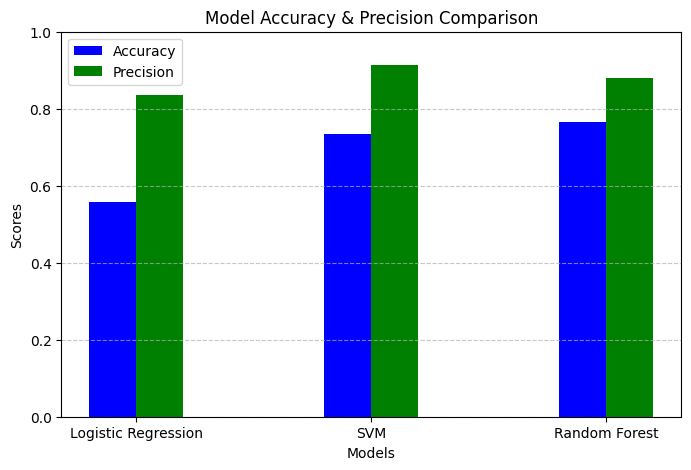

In [26]:
models_list = list(results.keys())
accuracy_values = [results[m]["Accuracy"] for m in models_list]
precision_values = [results[m]["Precision"] for m in models_list]

# Label locations
x = np.arange(len(models_list))  
# Bar width
width = 0.2  

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy', color='blue')
rects2 = ax.bar(x + width/2, precision_values, width, label='Precision', color='green')

ax.set_xlabel("Models")
ax.set_ylabel("Scores")
ax.set_title("Model Accuracy & Precision Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models_list)
ax.legend()
# Score range 0 to 1
plt.ylim(0, 1)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
#Output plot
plt.show()


# model & vectorizer

In [27]:
VECTOR_PATH = os.path.join(BASE_DIR, "../models/tfidf_vectorizer.pkl")
CLASSIFIER_PATH = os.path.join(BASE_DIR, "random_forest.pkl")
vectorizer = joblib.load(VECTOR_PATH)
model = joblib.load(CLASSIFIER_PATH)


# Job Description Input

In [28]:
job_description = """data science"""
job_vector = vectorizer.transform([clean_text(job_description)])

# Compute similarity scores

In [29]:
similarity_scores = cosine_similarity(job_vector, X)
# Add scores to dataset
df["Similarity_Score"] = similarity_scores[0]

# Sort candidates in an ascending order

In [30]:
ranked_resumes = df.sort_values(by="Similarity_Score", ascending=False)
ranked_resumes = ranked_resumes.sort_values(by="Similarity_Score", ascending=False)
ranked_resumes["Resume"] = ranked_resumes["Resume"].str.replace(r"\r\n", " ", regex=True)

# List top matches

In [31]:
from IPython.display import display
display(ranked_resumes[["Resume", "Similarity_Score"]].head(10))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Processing Time: {elapsed_time:.2f} seconds")

,Resume,Similarity_Score
137,"â¢ Operating systems:-Linux- Ubuntu, Windows ...",0.071907
18,Computer Knowledge: â¢ Proficient in basic us...,0.062869
53,SKILLS: Computer: â¢ Can easily operate in Op...,0.057645
56,Education Details B.E in Civil Engineering C...,0.051394
149,"Technical Skills â¢ Languages: C#, ASP .NET M...",0.034150
40,Education Details May 1999 to September 2002 ...,0.030970
163,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",0.026848
135,Education Details Hadoop Developer Hadoop ...,0.022053
83,Education Details July 2008 to February 2012 ...,0.020215
78,IT Skills: Area Exposure Modeling Tool: Bizagi...,0.015050


Processing Time: 78.57 seconds
